In [1]:
%connect_info


{"key":"20678516-8ea5-40a0-b9d1-ece51d11dc9c","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9000,"control_port":9001,"shell_port":9002,"stdin_port":9003,"iopub_port":9004,"kernel_name":"python3112jvsc74a57bd04149aa2f31a7f8b5ff184e82bf464dce73529b69401cc2940ad6232b832b4da8"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v384704f07caff2ed3b77b34722cbbb2db465dd403.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne

%load_ext IPython.extensions.autoreload
%autoreload 2

from hypyp.signal import SynteticSignal


{'S1_D1': array([-0.36350842,  0.44258102]), 'S1_D2': array([-0.22320167,  0.40576885]), 'S2_D1': array([-0.36265582,  0.58856121]), 'S2_D3': array([-0.22222067,  0.73256339]), 'S3_D2': array([-0.16441369,  0.50113119]), 'S3_D3': array([-0.16428529,  0.68194555]), 'S3_D4': array([-0.08925055,  0.59318198]), 'S4_D2': array([-0.07516314,  0.38871844]), 'S4_D4': array([0.        , 0.48076923]), 'S4_D5': array([0.07516314, 0.38871844]), 'S5_D3': array([-0.07503474,  0.76184049]), 'S5_D4': array([0.        , 0.67307692]), 'S5_D6': array([0.07503474, 0.76184049]), 'S6_D4': array([0.08925055, 0.59318198]), 'S6_D5': array([0.16441369, 0.50113119]), 'S6_D6': array([0.16428529, 0.68194555]), 'S7_D5': array([0.22320167, 0.40576885]), 'S7_D7': array([0.36350842, 0.44258102]), 'S8_D6': array([0.22222067, 0.73256339]), 'S8_D7': array([0.36265582, 0.58856121])}


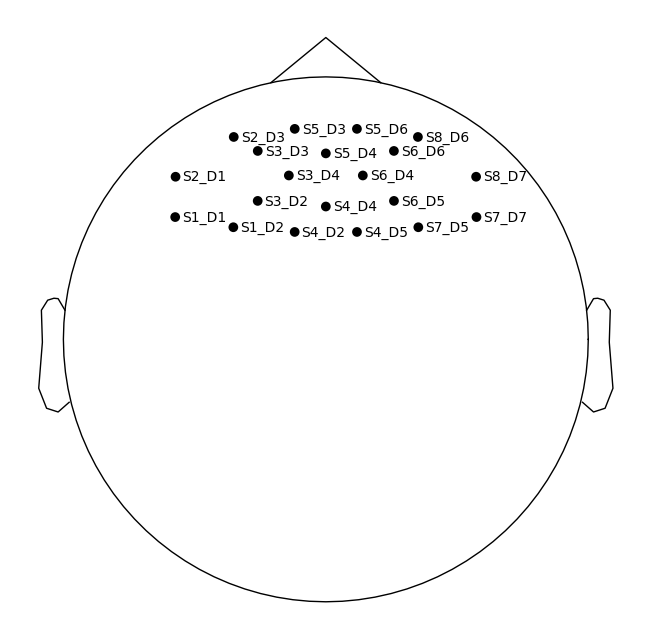

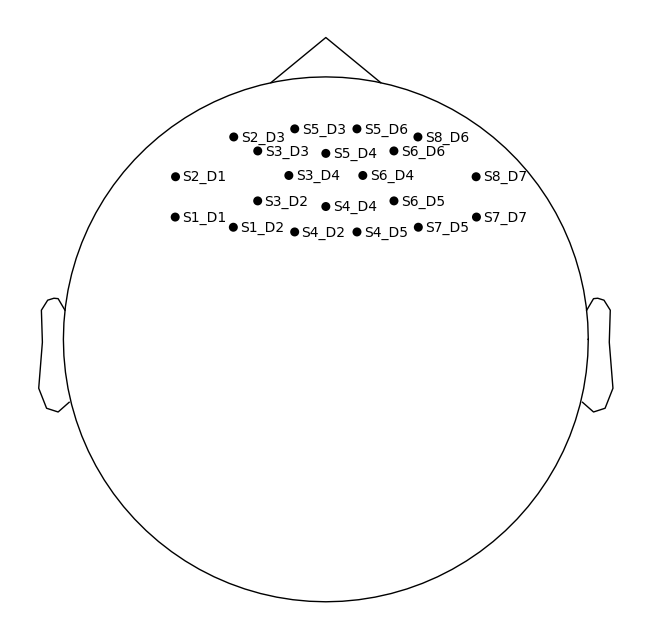

In [28]:
import scipy.io

# Load the .mat file
montage_file_path = "../data/fNIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002_probeInfo.mat"
mat_data = scipy.io.loadmat(montage_file_path)

# Explore the keys in the .mat file
#print(mat_data.keys())
probe_info = mat_data['probeInfo']
#print(probe_info['probes'])
probes = probe_info['probes'][0][0]
#print(probes['coords_s3'][0][0])
#probe = mat_data['probeInfo'][0,0][0]
#print(probe[0][0])

#src_positions = probes['coords_s3'][0][0]  # Shape: (n_sources, 3) - x, y, z coordinates
#det_positions = probes['coords_d3'][0][0]  # Shape: (n_detectors, 3) - x, y, z coordinates
#ch_positions = probes['coords_c3'][0][0]
#ch_positions = probes['normals_c'][0][0]
ch_positions = probes['coords_c2'][0][0]
ch_indices = probes['index_c'][0][0]

x_scale = 0.15
y_scale = 0.1

# Create a dictionary with channel names and corresponding coordinates
channels_2d = {}
for i, idx in enumerate(ch_indices):
    s, d = idx
    #ch_coords[f'S{s}_D{d}'] = ch_positions[i] * [x_scale, y_scale, z_scale] * 2
    channels_2d[f'S{s}_D{d}'] = ch_positions[i]
print(channels_2d)

nasion = [0, y_scale, 0]
lpa = [-x_scale, 0, 0]
rpa = [x_scale, 0, 0]

channels_3d = {ch: [x*x_scale, y*y_scale, 0] for ch, (x, y) in channels_2d.items()}

# Create a DigMontage
montage = mne.channels.make_dig_montage(
    ch_pos=channels_3d, 
    coord_frame='unknown',
    nasion=nasion,
    lpa=lpa,
    rpa=rpa,
)

# Visualize the montage
montage.plot(kind='topomap')


In [30]:
# Try with another file, a snirf that contains the montage info

file_path = '../data/fNIRS/DCARE_02_sub1.snirf'

raw = mne.io.read_raw_snirf(file_path)


Loading /home/patrice/work/ppsp/HyPyP-synchro/tutorial/../data/fNIRS/DCARE_02_sub1.snirf


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 13596 original time points ...


0 bad epochs dropped


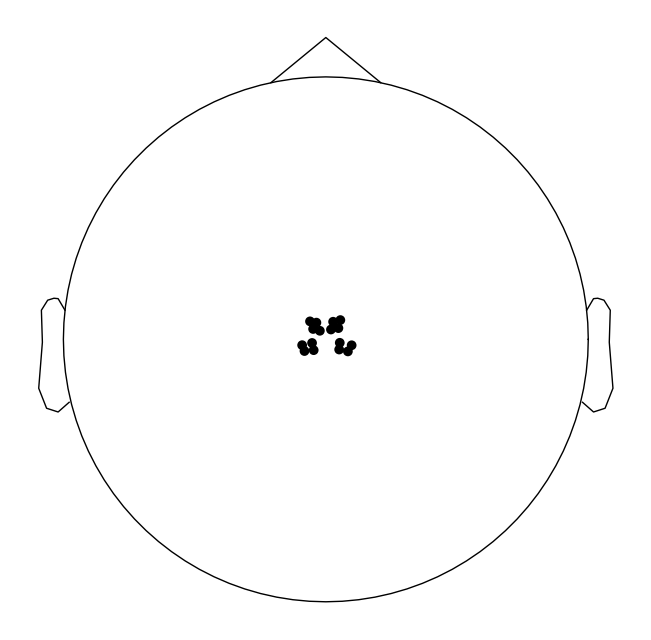

In [33]:
raw.info['chs']

# Define a dummy event for the entire data
n_samples = len(raw.times)
events = np.array([[0, 0, 1]])  # One event starting at time 0

# Create a single epoch spanning the entire duration
tmin = 0                      # Start at the beginning of the recording
tmax = raw.times[-1]          # End at the last time point
event_id = {'continuous': 1}  # Dummy event ID

# Create the epoch
epochs = mne.Epochs(
    raw, events, event_id, tmin=tmin, tmax=tmax,
    baseline=None, preload=True
)

_ = epochs.info.get_montage().plot(show_names=False)



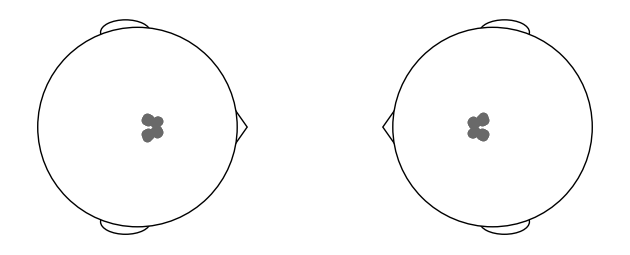

In [34]:
from hypyp.viz import plot_2d_topomap_inter, plot_sensors_2d_inter
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.axis("off")
plot_2d_topomap_inter(ax)
plot_sensors_2d_inter(epochs, epochs, lab = False) # bads are represented as squares
# plotting links according to sign (red for positiv#e values,
# blue for negative) and value (line thickness increases
# with the strength of connectivity)
#plot_links_2d_inter(epo1, epo2, C=C, threshold=threshold, steps=steps)
plt.tight_layout()
plt.show()
